In [3]:
%pip install requests

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import requests

#Get the pdf document path
pdf_path = "intro-to-algorithms.pdf"
filename = pdf_path

 #Download the pdf file from the url
if not os.path.exists(pdf_path):
    print(f"[INFO] File does not exist, downloading...")
    
    url = "https://www.cs.mcgill.ca/~akroit/math/compsci/Cormen%20Introduction%20to%20Algorithms.pdf"
    
    response = requests.get(url)
    
    if response.status_code == 200:
        #Open the file and save it
        with open(filename, "wb") as file:
            file.write(response.content)
            
        print(f"[INFO] The file has been downloaded and saved successfully as {filename}")
        
    else:
        print(f"[ERROR] Failed to download the file. Status Code: {response.status_code}")
else:
    print(f"[INFO] The file already exists: {filename}")




[INFO] The file already exists: intro-to-algorithms.pdf


We now need to open the PDF

In [5]:
%pip install PyMuPDF 
%pip install tqdm
%pip install re

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """ Performs minor formatting on text """
    text = text.replace("\n", " ")
    return text.strip()

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """ Extracts text from a PDF file and reads its contents """
    doc = fitz.open(pdf_path)
    pages_and_text = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_text.append({
            "page_number": page_number - 20,
            "page_char_count": len(text),
            "page_word_count": len(text.split(" ")),
            "page_sentence_count": len(text.split('.')),
            "page_token_count": len(text) / 4, #1 token = ~ 4 characters
            "text": text
        })
    return pages_and_text

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]
    
    
    

706it [00:01, 557.00it/s]


KeyboardInterrupt: 

In [ ]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 1227,
  'page_char_count': 1360,
  'page_word_count': 305,
  'page_sentence_count': 24,
  'page_token_count': 340.0,
  'text': 'Problems for Appendix D 1227 is det.V.x0; x1; : : : ; xn\x001// D Y 0\x14j <k\x14n\x001 .xk \x00 xj/ : (Hint: Multiply column i by \x00x0 and add it to column i C 1 for i D n \x00 1; n \x00 2; : : : ; 1, and then use induction.) D-2 Permutations deﬁned by matrix-vector multiplication over GF.2/ One class of permutations of the integers in the set Sn D f0; 1; 2; : : : ; 2n \x00 1g is deﬁned by matrix multiplication over GF.2/. For each integer x in Sn, we view its binary representation as an n-bit vector \x00x0 x1 x2 ::: xn\x001 \x01 ; where x D Pn\x001 iD0 xi2i. If A is an n \x02 n matrix in which each entry is either 0 or 1, then we can deﬁne a permutation mapping each value x in Sn to the number whose binary representation is the matrix-vector product Ax. Here, we perform all arithmetic over GF.2/: all values are either 0 or 1, and with one 

In [ ]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd

df = pd.DataFrame(pages_and_text)
df.head()


NameError: name 'pages_and_text' is not defined

In [ ]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count
count,1313.00,1313.00,1313.00,1313.0,1313.00
mean,636.00,1935.34,365.27,1.0,483.83
std,379.17,577.43,101.17,0.0,144.36
min,-20.00,0.00,1.00,1.0,0.00
25%,308.00,1603.00,310.00,1.0,400.75
50%,636.00,1974.00,370.00,1.0,493.50
75%,964.00,2334.00,434.00,1.0,583.50
max,1292.00,3275.00,639.00,1.0,818.75


Why would we care about token count? 

Token count is important to think about because: 
1. Embedding models don't deal with infinite tokens.
2. LLMs don't deal with infinite tokens.

For example, an embedding model may have been trained to embed sequences of 384 tokens into numerical space (sentence transformers `all-mpnet-base-v2`, see: https://www.sbert.net/docs/pretrained_models.html).

As for LLMs, they can't accept infinite tokens in their context window. 

### Further text processing (Splitting pages into sentences)

Two ways to do this: 
1. We've done this by splitting on `"."`. 
2. We can do this with an NLP library such as [spaCy](https://spacy.io/usage) and [nltk](https://nltk.org/).

Note to Self: spacy was downloaded and not added into the Notebook. Should be installed based on the instructions provided in spacy.io.

In [ ]:
from spacy.lang.en import English

nlp = English()

#Add a sentencizer pipeline, see https://spacy.io/api/sentencizer
nlp.add_pipe("sentencizer")

#Create document instance as an example
doc = nlp("This is a sentence. This is another sentence. I like Elephants.")
assert len(list(doc.sents)) == 3

# Print out our sentences split
list(doc.sents)

[This is a sentence., This is another sentence., I like Elephants.]

In [ ]:
for item in tqdm(pages_and_texts): 
    item["sentences"] = list(nlp(item["text"]).sents) # Group text into sentences and add to pages and texts
    
    # Make sure all sentences are strings (the default type is a spaCy datatype)
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    
    # Count the sentences 
    item["page_sentence_count_spacy"] = len(item["sentences"])

100%|██████████| 1313/1313 [00:01<00:00, 1143.01it/s]


In [ ]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy
count,1313.00,1313.00,1313.00,1313.00,1313.00,1313.00
mean,636.00,1935.34,365.27,30.08,483.83,14.71
std,379.17,577.43,101.17,13.90,144.36,8.01
min,-20.00,0.00,1.00,1.00,0.00,0.00
25%,308.00,1603.00,310.00,22.00,400.75,10.00
50%,636.00,1974.00,370.00,28.00,493.50,14.00
75%,964.00,2334.00,434.00,35.00,583.50,18.00
max,1292.00,3275.00,639.00,111.00,818.75,68.00


### Chunking our sentences together

The concept of splitting larger pieces of text into smaller ones is often referred to as text splitting or chunking. 

There is no 100% correct way of doing this. 

To keep it simple, we will split into groups of 10 sentences (however, can also try with 5, 7 or 8, whatever works).

There are frameworks such as [LangChain](https://python.langchain.com/docs/concepts/text_splitters/) that can help with this, but we will stick for Python for this tutorial.

Why we do this:
1. So our texts are easier to filter (smaller groups of text can be easier to inspect than larger passages of text)
2. So our text chunks can fit into our embedding model context window
3. So our contexts passed to an LLM can be more specific and focused.  

In [ ]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function to split lists of texts recursively into chunk size
# e.g. [20] -> [10, 10], [25] -> [10, 10, 5]
def split_list(input_list: list, 
               slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]
test_list = list(range(25))
split_list(test_list) 


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [ ]:
# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"]) 
    

100%|██████████| 1313/1313 [00:00<00:00, 548736.66it/s]


In [ ]:
random.sample(pages_and_texts, k=1)

[{'page_number': 667,
  'page_char_count': 1771,
  'page_word_count': 329,
  'page_sentence_count': 46,
  'page_token_count': 442.75,
  'text': '24.4 Difference constraints and shortest paths 667 0 0 0 0 0 0 –1 1 5 4 –1 –3 –3 0 –5 –3 0 –1 –4 v3 v2 v1 v5 v0 v4 Figure 24.8 The constraint graph corresponding to the system (24.3)–(24.10) of difference con- straints. The value of ı.\x170; \x17i/ appears in each vertex \x17i. One feasible solution to the system is x D .\x005; \x003; 0; \x001; \x004/. The constraint graph contains the additional vertex \x170, as we shall see shortly, to guarantee that the graph has some vertex which can reach all other vertices. Thus, the vertex set V consists of a vertex \x17i for each unknown xi, plus an additional vertex \x170. The edge set E contains an edge for each difference constraint, plus an edge .\x170; \x17i/ for each unknown xi. If xj \x00 xi \x14 bk is a difference constraint, then the weight of edge .\x17i; \x17j/ is w.\x17i; \x17j/ D bk. The w

In [ ]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy,num_chunks
count,1313.00,1313.00,1313.00,1313.00,1313.00,1313.00,1313.00
mean,636.00,1935.34,365.27,30.08,483.83,14.71,1.92
std,379.17,577.43,101.17,13.90,144.36,8.01,0.84
min,-20.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,308.00,1603.00,310.00,22.00,400.75,10.00,1.00
50%,636.00,1974.00,370.00,28.00,493.50,14.00,2.00
75%,964.00,2334.00,434.00,35.00,583.50,18.00,2.00
max,1292.00,3275.00,639.00,111.00,818.75,68.00,7.00


### Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation. 

That'll give us a good level of granularity.

Meaning, we can dive specifically into the text sample that was used in our model.

In [ ]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        # Join the sentences into a paragraph like structure, aka join the list of sentences into one paragraph
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)
        
        chunk_dict["sentence_chunk"] = joined_sentence_chunk
        
        # Get some stats on our chunks
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~ 4 chars
        
        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)
        
        

100%|██████████| 1313/1313 [00:00<00:00, 32985.07it/s]


2517

In [ ]:
random.sample(pages_and_chunks, k = 1)

[{'page_number': 876,
  'sentence_chunk': '876 Chapter 29 Linear Programming Lemma 29.3 Let I be a set of indices. For each j 2 I, let ˛j and ˇj be real numbers, and let xj be a real-valued variable. Let be any real number. Suppose that for any settings of the xj, we have X j2I ˛jxj D C X j2I ˇjxj : (29.78) Then ˛j D ˇj for each j 2 I, and D 0. Proof Since equation (29.78) holds for any values of the xj, we can use particular values to draw conclusions about ˛, ˇ, and . If we let xj D 0 for each j 2 I, we conclude that D 0. Now pick an arbitrary index j 2 I, and set xj D 1 and xk D 0 for all k ¤ j . Then we must have ˛j D ˇj. Since we picked j as any index in I, we conclude that ˛j D ˇj for each j 2 I. A particular linear program has many different slack forms; recall that each slack form has the same set of feasible and optimal solutions as the original linear pro- gram. We now show that the slack form of a linear program is uniquely determined by the set of basic variables.',
  'chun

In [ ]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,2517.00,2517.00,2517.00,2517.00
mean,669.58,1008.50,189.95,252.12
std,390.17,515.08,105.23,128.77
min,-20.00,9.00,2.00,2.25
25%,340.00,585.00,100.00,146.25
50%,668.00,1046.00,191.00,261.50
75%,1018.00,1381.00,263.00,345.25
max,1292.00,2607.00,548.00,651.75


### Filter chunks of text for short chunks

These chunks may not contain much useful information.

In [ ]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk Token Count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk Token Count: 14.0 | Text: The expected value of the random variable X representing
Chunk Token Count: 8.25 | Text: The total time is thus O.n lg n/.
Chunk Token Count: 11.75 | Text: 505 insertion into binary search trees, 294–295
Chunk Token Count: 6.5 | Text: V Advanced Data Structures
Chunk Token Count: 4.5 | Text: The relation <x is


In [ ]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -20,
  'sentence_chunk': 'A L G O R I T H M S I N T R O D U C T I O N T O T H I R D E D I T I O N T H O M A S H. C H A R L E S E.    R O N A L D L. C L I F F O R D S T E I N R I V E S T L E I S E R S O N C O R M E N',
  'chunk_char_count': 189,
  'chunk_word_count': 95,
  'chunk_token_count': 47.25},
 {'page_number': -17,
  'sentence_chunk': 'Thomas H. Cormen Charles E. Leiserson Ronald L. Rivest Clifford Stein Introduction to Algorithms Third Edition The MIT Press Cambridge, Massachusetts London, England',
  'chunk_char_count': 165,
  'chunk_word_count': 23,
  'chunk_token_count': 41.25}]

In [ ]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': 236,
  'sentence_chunk': 'In a circular list, the pre\x17 pointer of the head of the list points to the tail, and the next pointer of the tail of the list points to the head. We can think of a circular list as a ring of',
  'chunk_char_count': 190,
  'chunk_word_count': 42,
  'chunk_token_count': 47.5}]

# Embedding Our Text Chunks

[Embeddings](https://vickiboykis.com/what_are_embeddings/) are a broad but powerful concept.

While humans understand text, machines understand numbers. 

What we'd like to do: 
- Turn our text chunks into numbers, specifically, embeddings. 

A useful numerical representation.

The best part about embeddings is that they are a *learned* representation.

```
{"the": 0,
"a": 1, 
...
...}
```

In [ ]:
%pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu")

# Create a list of sentences
sentences = ["Hello, my name is John and I like football.",
             "AI is so cool nowadays.",
             "Embeddings are a revolutionary technology",
             "I went to the farm the other day."]

embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}")
    print("")

Note: you may need to restart the kernel to use updated packages.
Sentence: Hello, my name is John and I like football.
Embedding: [ 1.29194220e-03  7.20893592e-02 -1.17977790e-03 -2.62890253e-02
  3.96553315e-02 -4.10587005e-02 -5.22783026e-02  7.64403446e-03
 -1.27780419e-02 -1.90602019e-04  3.95361073e-02 -2.21871939e-02
  1.24161486e-02  1.51262730e-02  3.52668054e-02 -4.13680039e-02
  4.56340332e-03 -6.52403831e-02  6.32882938e-02 -7.24698836e-03
  4.18687873e-02  5.12758212e-04 -1.46308355e-02 -1.39766848e-02
 -5.79854287e-02  2.54586097e-02 -1.36849908e-02  4.45831427e-03
 -1.05274487e-02  7.11089149e-02 -9.09978990e-03 -3.25113684e-02
 -3.53915337e-03 -1.13454703e-02  1.58650278e-06  1.18198972e-02
 -1.19213499e-02 -2.13643741e-02  7.80989155e-02  2.57006002e-04
  1.19429715e-02 -3.15609947e-03 -1.37991933e-02 -3.18820425e-03
 -8.89387634e-03  6.08826894e-03  5.48814870e-02  6.89790631e-03
  1.10323401e-02  3.49150077e-02 -6.11934531e-03 -3.25804055e-02
 -9.72216111e-03 -1.9384

In [ ]:
%%time
import torch

device = "mps" if torch.backends.mps.is_available() else "cpu"
embedding_model.to(device)

#Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len): 
    item["embedding"] = embedding_model.encode(item["sentence_chunk"]) 

100%|██████████| 2441/2441 [02:15<00:00, 17.96it/s]

CPU times: user 55.7 s, sys: 12.9 s, total: 1min 8s
Wall time: 2min 16s


In [ ]:
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
text_chunks[419]

'The elements in the queue reside in locations Q:head; Q:head C 1; : : : ; Q:tail \x00 1, where we “wrap around” in the sense that location 1 immediately follows location n in a circular order. When Q:head D Q:tail, the queue is empty. Initially, we have Q:head D Q:tail D 1. If we attempt to dequeue an element from an empty queue, the queue underﬂows.'

In [ ]:
len(text_chunks)

2441

In [ ]:
%%time

#Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks, 
                                                batch_size = 32, # Batch Size -> How many chunks to look at, at one time. Can experiment to see which batch size leads to best results
                                                convert_to_tensor=True)
text_chunk_embeddings

CPU times: user 3.3 s, sys: 2.38 s, total: 5.68 s
Wall time: 58.6 s


tensor([[-0.0655, -0.0349, -0.0133,  ...,  0.0538, -0.0036,  0.0226],
        [-0.0205, -0.0198, -0.0266,  ..., -0.0105,  0.0293,  0.0002],
        [-0.0261,  0.0296, -0.0303,  ...,  0.0027, -0.0106, -0.0087],
        ...,
        [-0.0291, -0.0882, -0.0420,  ..., -0.0110, -0.0173, -0.0282],
        [-0.0380, -0.0687, -0.0491,  ..., -0.0103, -0.0122, -0.0500],
        [-0.0146,  0.0466, -0.0223,  ...,  0.0301,  0.0003, -0.0313]],
       device='mps:0')

## Save Embeddings to a File

In [ ]:
pages_and_chunks_over_min_token_len[419]

{'page_number': 234,
 'sentence_chunk': 'The elements in the queue reside in locations Q:head; Q:head C 1; : : : ; Q:tail \x00 1, where we “wrap around” in the sense that location 1 immediately follows location n in a circular order. When Q:head D Q:tail, the queue is empty. Initially, we have Q:head D Q:tail D 1. If we attempt to dequeue an element from an empty queue, the queue underﬂows.',
 'chunk_char_count': 349,
 'chunk_word_count': 67,
 'chunk_token_count': 87.25,
 'embedding': array([-3.73915257e-03, -7.22255930e-02, -2.66842470e-02,  1.62575033e-03,
        -1.98275801e-02,  3.32464539e-02, -2.43265973e-03, -7.36244544e-02,
        -7.59301987e-03,  3.68874557e-02,  2.76616644e-02,  3.07645625e-03,
         2.98099909e-02, -2.59931292e-02, -2.53142435e-02, -4.42899615e-02,
        -3.92151391e-03, -3.12734349e-03, -4.75436114e-02,  1.70888864e-02,
        -3.14661190e-02,  3.34225856e-02, -7.10220188e-02, -5.00677386e-04,
         6.45025596e-02, -4.32380848e-02, -3.62718999e-

In [ ]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [ ]:
# Import saved file and view
text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-20,A L G O R I T H M S I N T R O D U C T I O N T ...,189,95,47.25,[-6.54905811e-02 -3.49067412e-02 -1.33199217e-...
1,-17,Thomas H. Cormen Charles E. Leiserson Ronald L...,165,23,41.25,[-2.05252226e-02 -1.97693892e-02 -2.66365092e-...
2,-16,c 2009 Massachusetts Institute of Technology A...,710,104,177.50,[-2.60746311e-02 2.95773614e-02 -3.02987806e-...
3,-16,paper)—ISBN 978-0-262-53305-8 (pbk. :alk.paper...,174,26,43.50,[-1.62581522e-02 -1.00865951e-02 -2.69123074e-...
4,-15,Contents Preface xiii I Foundations Introducti...,876,134,219.00,[ 3.65013741e-02 2.32191267e-03 -9.05455835e-...


If your embedding database is really large (e.g. over 100k - 1M samples), you might want to look into using a [vector database](https://en.wikipedia.org/wiki/Vector_database) for storage

# Part II. Rag - Search & Answer (Querying an input and finding best outputs)

RAG Goal: Retrieve relevant passages based on a query and use those passages to augment an input to an LLM so it can generate an output based on those relevant passages.

### Similarity Search

Embeddings can be used for almost any type of data. 

For example, you can turn images into embeddings, sound into embeddings, text into embeddings, etc...

Comparing embeddings is known as similarity search, vector search, semantic search.

In our case, we want to query our nutrition textbook passages based on semantics or "vibe".

So if I search for "depth first search", I should get relevant passages to that text but that may not contain the exact phrase "depth first search".

Whereas, with keyword search, if I search "apple", I get back passages that specifically contain "apple".


In [9]:
import random
from re import I

import torch
import numpy as np
import pandas as pd

device = "mps" if torch.backends.mps.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embeddings_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string type when it got saved as a CSV)
text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert embeddings into a torch.tensor
embeddings = torch.tensor(np.stack(text_chunks_and_embeddings_df["embedding"].tolist(), axis=0), dtype=torch.float32).to(device)

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")

text_chunks_and_embeddings_df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-20,A L G O R I T H M S I N T R O D U C T I O N T ...,189,95,47.25,"[-0.0654905811, -0.0349067412, -0.0133199217, ..."
1,-17,Thomas H. Cormen Charles E. Leiserson Ronald L...,165,23,41.25,"[-0.0205252226, -0.0197693892, -0.0266365092, ..."
2,-16,c 2009 Massachusetts Institute of Technology A...,710,104,177.50,"[-0.0260746311, 0.0295773614, -0.0302987806, 0..."
3,-16,paper)—ISBN 978-0-262-53305-8 (pbk. :alk.paper...,174,26,43.50,"[-0.0162581522, -0.0100865951, -0.0269123074, ..."
4,-15,Contents Preface xiii I Foundations Introducti...,876,134,219.00,"[0.0365013741, 0.00232191267, -0.00905455835, ..."
...,...,...,...,...,...,...
2436,1290,"and 3-CNF satisﬁability, 1049 two-pass method,...",471,63,117.75,"[-0.0335179716, -0.0101336623, -0.0212319065, ..."
2437,1291,Index 1291 computing a minimum spanning tree i...,1426,205,356.50,"[-0.0144766113, -0.0365767814, -0.0245885979, ..."
2438,1291,"Vandermonde matrix, 902, 1226pr.van Emde Boas ...",804,110,201.00,"[-0.0291395839, -0.0881577656, -0.0420230404, ..."
2439,1292,"1292 Index vector, 1218, 1222–1224 convolution...",800,110,200.00,"[-0.0379782692, -0.0687104091, -0.049102392, 0..."


In [11]:
embeddings.shape

torch.Size([2441, 768])

**Note**: To use dot product for comparison, ensure vector sizes are of same shape (e.g. 768) and tensors/vectors are in the same datatype (e.g. both are in **torch.float32**)

In [12]:
# Create model
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device)

Embedding Model Ready, let's create a small semantic search pipeline

In essence, we want to search for a query (E.g. "depth first search") and get back relevant passages from our textbook.

We can do so with the following steps: 
1. Define a query string.
2. Convert the query string into an embedding.
3. Perform a **dot product** or a **cosine similarity function** between the text embeddings and the query embedding.
4. Sort the results from 3 in descending order.

In [13]:
# 1. Define the query
query = "finance"
print(f"Query: {query}")

# 2. Embed the query
# Note: Its important to embed the query with the same model that was used to embed the passages. 
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

# 3. Get similarity scores with dot product (use cosine similarity scores if outputs of model are not normalized)
from time import perf_counter as timer

start_time = timer() 
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (keep this to top 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product




Query: finance
[INFO] Time taken to get scores on 2441 embeddings: 0.00426 seconds.


torch.return_types.topk(
values=tensor([0.4025, 0.3678, 0.3426, 0.3413, 0.3403], device='mps:0'),
indices=tensor([735, 737, 148, 736, 144], device='mps:0'))

In [14]:
pages_and_chunks[148]

{'page_number': 70,
 'sentence_chunk': '70 Chapter 4 Divide-and-Conquer 13 1 –3 2 –25 3 20 4 –3 5 –16 6 –23 7 8 9 10 maximum subarray 11 18 12 20 13 –7 14 12 15 7 16 –5 –22 15 –4 A Figure 4.3 The change in stock prices as a maximum-subarray problem. Here, the subar- ray AŒ8 : : 11\x8d, with sum 43, has the greatest sum of any contiguous subarray of array A. that although computing the cost of one subarray might take time proportional to the length of the subarray, when computing all ‚.n2/ subarray sums, we can orga- nize the computation so that each subarray sum takes O.1/ time, given the values of previously computed subarray sums, so that the brute-force solution takes ‚.n2/ time. So let us seek a more efﬁcient solution to the maximum-subarray problem. When doing so, we will usually speak of “a” maximum subarray rather than “the” maximum subarray, since there could be more than one subarray that achieves the maximum sum. The maximum-subarray problem is interesting only when the array

We can see that searching over embeddings is very fast even if we exhaustively do so. 

But if you had 10M+ embeddings, you likely want to create an index. 

An index is like letters in a dictionary. 

For example, if you wanted to find "duck", you would probably start with "d", then find words close to "du..." etc.

An index helps to narrow the search down. 

A popular indexing library for vector search is [FAISS](https://github.com/facebookresearch/faiss).

One technique that the library provides is [approximate nearest neighbour search (ANN)](https://en.wikipedia.org/wiki/Nearest_neighbor_search#:~:text=Nearest%20neighbor%20search%20(NNS)%2C,the%20larger%20the%20function%20values.) 

Let's make the vector search results pretty. 

In [15]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [29]:
query = "finance"
print(f"Query: '{query}'\n")
print("Results:")

#Loop through zipped together scores and indices from torch.topk 
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page Number: {pages_and_chunks[idx]['page_number']}")
    print("\n")
    

Query: 'finance'

Results:
Score: 0.4025
Text:
Design an algorithm that, given the numbers of characters after which to break,
determines a least-cost way to sequence those breaks. More formally, given a
string S with n characters and an array LŒ1 : : m containing the break points,
com- pute the lowest cost for a sequence of breaks, along with a sequence of
breaks that achieves this cost.15-10 Planning an investment strategy Your
knowledge of algorithms helps you obtain an exciting job with the Acme Computer
Company, along with a $10,000 signing bonus. You decide to invest this money
with the goal of maximizing your return at the end of 10 years. You decide to
use the Amalgamated Investment Company to manage your investments. Amalgamated
Investments requires you to observe the following rules. It offers n different
investments, numbered 1 through n. In each year j , investment i provides a
return rate of rij. In other words, if you invest d dollars in investment i in
year j , then at 

Note: We could potentially improve the order of these results with a reranking model. A model that has been trained specifically to take search results (e.g. the top 25 semantic results) and rank them from most likely top-1 to least likely. 

See [here](https://huggingface.co/mixedbread-ai/mxbai-rerank-large-v1) for an open-source reranking model

To check our results, what if we wanted to automatically surface the page of texts related to our query?

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


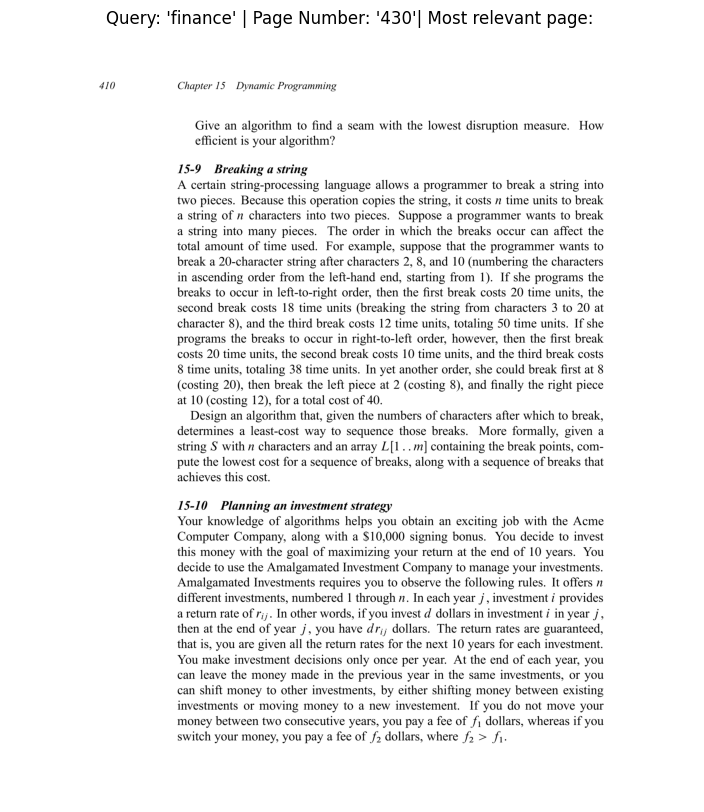

In [17]:
%pip install matplotlib
import fitz

pdf_path="intro-to-algorithms.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(410 + 20) # note: pages of pdf start at 20+
page_num = page.number

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Save image (Optional)
# img.save("output_filename.png")

doc.close()

# Convert the image into a numpy array
img_array = np.frombuffer(img.samples_mv, 
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Page Number: '{page_num}'| Most relevant page: ")
plt.axis("off")
plt.show()

## Theory - Similarity Measures: Dot Product & Cosine Similarity
Two of the most common similarity measures between vectors are dot product and cosine similarity
In essence, closer vectors will have higher scores, further away vectors will have lower scores. 

Vectors have direction (Same direction -> Similar semantic meanings) and magnitude (Higher magnitude -> Higher confidence in choice of vector embedding)

Focus is on **direction**


| Similarity measure | Description | Code |
| ----- | ----- | ----- |
| [Dot Product](https://en.wikipedia.org/wiki/Dot_product) | - Measure of magnitude and direction between two vectors<br>- Vectors that are aligned in direction and magnitude have a higher positive value<br>- Vectors that are opposite in direction and magnitude have a higher negative value | [`torch.dot`](https://pytorch.org/docs/stable/generated/torch.dot.html), [`np.dot`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html), [`sentence_transformers.util.dot_score`](https://www.sbert.net/docs/package_reference/util.html#sentence_transformers.util.dot_score) |
| [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) | - Vectors get normalized by magnitude/[Euclidean norm](https://en.wikipedia.org/wiki/Norm_(mathematics))/L2 norm so they have unit length and are compared more so on direction<br>- Vectors that are aligned in direction have a value close to 1<br>- Vectors that are opposite in direction have a value close to -1 | [`torch.nn.functional.cosine_similarity`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cosine_similarity.html), [`1 - scipy.spatial.distance.cosine`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html) (subtract the distance from 1 for similarity measure), [`sentence_transformers.util.cos_sim`](https://www.sbert.net/docs/package_reference/util.html#sentence_transformers.util.cos_sim) |

The Hugging Face AI Model, ```all-mpnet-base-v2```, outputs normalized outputs so dot product and cosine similarity return the same results. However, dot product is faster as normalization is not required. 

Let's look at an example for both to compare the results: 

In [18]:
import torch

def dot_product(vector1, vector2): 
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)
    
    # Get Euclidean/L2 Norm
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))
    
    return dot_product / (norm_vector1 * norm_vector2)

# Example vectors/tensors
vector1 = torch.tensor([1,2,3], dtype=torch.float32)
vector2 = torch.tensor([1,2,3], dtype=torch.float32)
vector3 = torch.tensor([4,5,6], dtype=torch.float32)
vector4 = torch.tensor([-1,-2,-3], dtype=torch.float32)
vector5 = torch.tensor([2,-3,1.3333333], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector 1 and vector 2: ", dot_product(vector1, vector2))
print("Dot product between vector 1 and vector 3: ", dot_product(vector1, vector3))
print("Dot product between vector 1 and vector 4: ", dot_product(vector1, vector4))

# Cosine Similarity
print("Cosine Similarity between vector 1 and vector 2: ", cosine_similarity(vector1, vector2))
print("Cosine Similarity between vector 1 and vector 3: ", cosine_similarity(vector1, vector3))
print("Cosine Similarity between vector 1 and vector 4: ", cosine_similarity(vector1, vector4))
print("Cosine Similarity between vector 1 and vector 5: ", cosine_similarity(vector1, vector5))

Dot product between vector 1 and vector 2:  tensor(14.)
Dot product between vector 1 and vector 3:  tensor(32.)
Dot product between vector 1 and vector 4:  tensor(-14.)
Cosine Similarity between vector 1 and vector 2:  tensor(1.0000)
Cosine Similarity between vector 1 and vector 3:  tensor(0.9746)
Cosine Similarity between vector 1 and vector 4:  tensor(-1.0000)
Cosine Similarity between vector 1 and vector 5:  tensor(0.)


# Functionizing the semantic search pipeline

**Lets put all of the steps from above for semantic search into a function or two so that the workflow can be repeated.**

In [21]:
from tracemalloc import start


def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model, 
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query using the embedding_model and returns top k scores and indices from the embeddings.
    """
    
    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)
    
    # Get dot product scores on embeddings 
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()
    
    if print_time:
        print(f"[INFO] Time taken to get scores on ({len(embeddings)}) embeddings: {end_time-start_time:.5f} seconds.")
        
    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)
    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict] = pages_and_chunks,
                                 n_resources_to_return: int=5):
    """ Finds relevant classes given a query and prints them out along with their scores. """
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    #Loop through zipped together scores and indices from torch.topk 
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page Number: {pages_and_chunks[idx]['page_number']}")
        print("\n")
      

In [28]:
query="Optimising run time"
#retrieve_relevant_resources(query=query, embeddings=embeddings)
print_top_results_and_scores(query=query, embeddings=embeddings)

[INFO] Time taken to get scores on (2441) embeddings: 0.00140 seconds.
Score: 0.5406
Text:
1.2-3 What is the smallest value of n such that an algorithm whose running time
is 100n2 runs faster than an algorithm whose running time is 2n on the same
machine?Problems 1-1 Comparison of running times For each function f .n/ and
time t in the following table, determine the largest size n of a problem that
can be solved in time t, assuming that the algorithm to solve the problem takes
f .n/ microseconds.
Page Number: 14


Score: 0.5197
Text:
The company wishes to design a plan for the next n months. For each month i, the
company knows the demand di, that is, the number of machines that it will sell.
Let D D Pn iD1 di be the total demand over the next n months. The company keeps
a full-time staff who provide labor to manufacture up to m ma- chines per month.
If the company needs to make more than m machines in a given month, it can hire
additional, part-time labor, at a cost that works out to c

## Getting an LLM for Local Generation

We want to focus on local generation. 

This will also work with an LLM API

> Which LLM to use? 

Two main questions to ask from this: 
1. Do I want to run it locally?
2. If yes, how much compute power can I dedicate?


